In [27]:
import numpy as np
import matplotlib.pyplot as plt
import math
import ctypes as ct
import scipy.interpolate



# Define wing parameters

# rho = 1.225
# mu = 1.789e-5
# V_inf = 60  #[m/s]
# alpha = 5   # angle of attack [deg]
# a_0 = 2*np.pi
# Weight = 550*9.81  #[N]
# Bank_Angle = 20    #[deg]
# Span = 0
# AR = 0
# Area = 0






ModuleNotFoundError: No module named 'aerofiles'

In [2]:
# Function to read airfoil data at each station

def GetAirfoilData(Filename):
    with open(Filename, 'r') as infile:
        AirfoilData = np.loadtxt(infile, dtype=str, skiprows=0, unpack=True)
    
    return AirfoilData

In [3]:
# Function to read wing geometry

def GetWingData(Filename):
    with open(Filename, 'r') as infile:
        WingData = np.loadtxt(infile, dtype=float, skiprows=0, unpack=True)
    area = 0
    span = 0
    
    for i in range(0,len(WingData[0]),1):
        span = span + WingData[2][i]
        area = area + ((WingData[0][i] + WingData[1][i])/2)*WingData[2][i]
    
    AR = 2*(span**2)/area
    
    return area, span,AR,WingData
    



In [4]:
def CallXfoilcl(Cl, Re, AirfoilName, Flap):

    mydll = ct.cdll.LoadLibrary("D:\XFOIL\XFOIL.dll")

    ISCONV = ct.c_bool(False)
    RE_IN = ct.c_double(Re)
    CL_IN = ct.c_double(Cl)
    array = (ct.c_double * 11) (0,0,0,0,0,0,0,Flap,0.86,-0.008,0)
#FileName = 'D:\XFOIL\T12'


    my_string = AirfoilName.encode() # Convert string to bytes



    _= mydll.xfoil_cl(ct.byref(array), ct.byref(CL_IN),ct.byref(RE_IN),ct.byref(ISCONV),ct.c_char_p(my_string))

            # Array1(1) = ADEG
            # Array1(2) = CD
            # Array1(3) = CDF
            # Array1(4) = CM
            # Array1(5) = HMOM
            # Array1(6) = HFX
            # Array1(7) = HFY

    return array[0],array[1],array[3]        
                

In [38]:
#SAMPLE CODE

Area,Span,AR, WingData = GetWingData("wing_18.dat")
print(WingData)
print("Number of panels => " + str(WingData[0].size))
print("Aspect Ratio => " + str(AR))
print("Area => " + str(Area*2))
print("Span => " + str(Span*2))
#print(dir(WingData))

[[ 0.756       0.718       0.615       0.479       0.32      ]
 [ 0.718       0.615       0.479       0.32        0.2       ]
 [ 1.598       2.602       1.8         2.168       0.892     ]
 [ 1.17700929  1.73317762  0.98190798  0.8606      0.2194    ]
 [ 2.          2.          4.24        6.47       18.93      ]
 [ 1.59702753  2.60041654  1.79507858  2.154       0.84444444]]
Number of panels => 5
Aspect Ratio => 32.86897135803803
Area => 9.989189999999999
Span => 18.119999999999997


In [39]:
#SAMPLE CODE

AirfoilData  = GetAirfoilData("Airfoil_Data.dat")
print(AirfoilData)


for i in range(0,len(AirfoilData[0]),1):
    Re = rho*V_inf*float(AirfoilData[1][i])/mu
    
    # call XFOIL DLL
    AOA, Cd,Cm = CallXfoilcl(0,Re,AirfoilData[0][i],0)
    
    print(i+1,AirfoilData[1][i],Re,AOA, Cd, Cm)
    

[['d:\\Xfoil\\B20' 'd:\\Xfoil\\BeT1' 'd:\\Xfoil\\T12' 'd:\\Xfoil\\TeN1'
  'd:\\Xfoil\\N13' 'd:\\Xfoil\\N16']
 ['0.756' '0.718' '0.615' '0.479' '0.32' '0.20']]
1 0.756 3105980.9949692567 -1.7581003904342651 0.006385625805705786 -0.020326778292655945
2 0.718 2949860.2571268864 -1.7503443956375122 0.006452887784689665 -0.02002098225057125
3 0.615 2526690.888764673 -1.7417280673980713 0.006648407783359289 -0.01958340033888817
4 0.479 1967942.9849077696 -1.756992220878601 0.007022218778729439 -0.018958717584609985
5 0.32 1314700.9502515371 -1.7886735200881958 0.007732117082923651 -0.018262004479765892
6 0.20 821688.0939072107 -2.090463399887085 0.008845973759889603 -0.029011940583586693


In [6]:
# Function to divide wing into n sections, returns chord lengths array
#NOT USED


def WingDivide(WingData,n):
    number_of_panels = WingData[0].size

    #determine wing span from wing file
    span = 0
    if number_of_panels > 1:
        for panel_length in WingData[5]:
            span = span + panel_length 
    else:
        span = WingData[5]
        
    #print("Wing span => " + str(2*span))
    
    
    # divide wing into n sections
    chords = np.zeros(n, dtype=float)
    current_panel = 0 
    current_span_pos = WingData[5][0]
    i = 0
    for y_pos in np.linspace(0,span, n):
           
        if y_pos > current_span_pos:
            current_panel = current_panel + 1
            current_span_pos = current_span_pos + WingData[5][current_panel]
        
        chords[i] = ((WingData[0][current_panel] - WingData[1][current_panel]) / WingData[5][current_panel]) * (current_span_pos - y_pos) + WingData[1][current_panel]
        i += 1
    #print(np.stack((np.linspace(0,span,n),chords),axis=1))    
    return(np.stack((np.linspace(0,span,n),chords),axis=1))
 
    
    

In [5]:
def Get_Chord(WingData,y_pos):
    chord = 0
    number_of_panels = WingData[0].size

    #determine wing span from wing file
    span = 0
    if number_of_panels > 1:
        for panel_length in WingData[2]:
            span = span + panel_length 
    else:
        span = WingData[2]
        
    #print("Wing half span => " + str(span))
    
    
   
   
    current_panel = 0
    current_span_pos = WingData[2][0]   #outer section of current panel
     
    while current_panel <= number_of_panels+1:
        if y_pos < current_span_pos:
                chord = ((WingData[0][current_panel] - WingData[1][current_panel]) / WingData[2][current_panel]) * (current_span_pos - y_pos) + WingData[1][current_panel]
                break
        
        current_panel += 1 
        current_span_pos = current_span_pos + WingData[2][current_panel]
               
        #print(current_panel,current_span_pos)
        
    
    
    #print(np.stack((np.linspace(0,span,n),chords),axis=1))    
    return(chord)

In [6]:
def Solve_LL(wingdata,span,AR,n):
    
    theta_range = np.linspace(90,0.01,n)
    AMatrix = np.ones(shape=(n,n))
    X = np.ones(n)
    delta = 0
    Cl = np.zeros(n)
    y_pos = np.zeros(n)
    
    
    i = 0
    for theta in theta_range:
        unit_y = -math.cos(np.deg2rad(theta)) 
        c = Get_Chord(wingdata,-unit_y*span)
        mu = c*a_0/(8*span)
        
        X[i] = mu*(np.deg2rad(alpha))*(math.sin(np.deg2rad(theta)))
        for j in range(0,n,1):
            AMatrix[i][j] = (math.sin(((j+1)*2 -1)*np.deg2rad(theta)))*(((j+1)*2-1)*mu + (math.sin(np.deg2rad(theta))))
        
        y_pos[i] = -unit_y*span
        i+=1
    
    #print(A)
    #print(X)      
    #A = np.matmul(np.linalg.inv(AMatrix),X)
    A = np.linalg.solve(AMatrix, X)
    
    
    for i in range(1,n,1):
        delta = delta +((i+1)*2-1)*(A[i]**2)/(A[0]**2)

    #e =  (1/(1+delta))     

    k = 0
    for theta in theta_range:  
        for j in range(0,n,1):
            unit_y = -math.cos(np.deg2rad(theta))
            c = Get_Chord(wingdata,-unit_y*span)
            Cl[k] = Cl[k]+ (8*span)*(A[j]*(math.sin(((j+1)*2-1)*np.deg2rad(theta)))) / c
            
        k+=1
           
    CL = A[0]*(np.pi)*AR
    Cl_unit = Cl/CL
    return(Cl_unit,y_pos,CL,delta) 
          
    

Span efficiency delta => 0.020374621855408743
CL => 0.5156641947923679


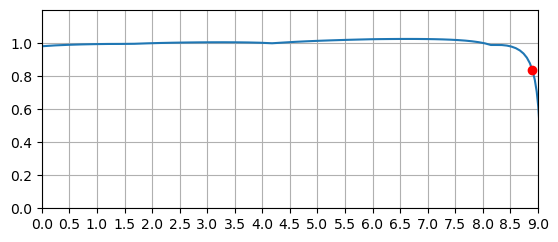

In [20]:
# SAMPLE CODE

n = 60
Area,Span,AR, WingData = GetWingData("wing_18.dat")
Cl,y_pos,CL,Delta = Solve_LL(WingData,Span,AR,n)   

print("Span efficiency delta => " + str(Delta))  
print("CL => " + str(CL))
#print(Cl)                 #Unit local Cl distribution
#print(y_pos)                 #span position for each local lift coefficient)


fig, ax = plt.subplots()
ax.set(xlim=(0, 9), xticks=np.arange(0, 9.5,0.5),
       ylim=(0, 1.2), yticks=np.arange(0, 1.2,0.2))
ax.plot(y_pos, Cl)
Cl_interp = scipy.interpolate.interp1d(y_pos,Cl)
spanpoint = 8.9
ax.plot(spanpoint,Cl_interp(spanpoint),'ro')
ax.grid(True)
ax.set_box_aspect(0.4)
plt.show()



In [43]:
# SAMPLE CODE


Cl_interp = scipy.interpolate.interp1d(y_pos,Cl)
spanpoint = 8.9
print(Cl_interp(spanpoint))


0.8367119987528995


In [25]:
def Wing_CD(WingFileName,AirfoilFileName,V,rho,mu,bank_angle,weight,Flap):
    
    # get wing definition data
    Area,Span,AR, WingData = GetWingData(WingFileName)
    
    #print("Area=" + str(Area*2) + "  " + "Span=" + str(Span*2) + "  " + "AR=" + str(AR))
    
    # calculte span efficiency and cl-distribution
    n = 60
    cl,y_pos,CL_theory,delta = Solve_LL(WingData,Span,AR,n)   
    
    #set cl interpolation function 
    cl_interp = scipy.interpolate.interp1d(y_pos,cl)
    
       
    CL = (2*weight) / (rho*(V**2)*Area*np.cos(np.deg2rad(bank_angle)))
    
    
    # calculate profile drag of the wing
    
    
    AirfoilData  = GetAirfoilData(AirfoilFileName)

     
    drag = 0
    area = 0
    span = 0.02
   
    
    
    Re_root = rho*V*float(AirfoilData[1][0])/mu
    AOA, Cd_root,Cm = CallXfoilcl(cl_interp(span)*CL,Re_root,AirfoilData[0][0],Flap)
    
    #print(span,cl_interp(span)*CL,AOA,Cd_root,Re_root)
    for i in range(0,len(WingData[0]),1):
        
        
        Re_tip = rho*V*float(AirfoilData[1][i+1])/mu
        
        span = span + 0.995*WingData[2][i]
        area = ((WingData[0][i] + WingData[1][i])/2)*WingData[2][i]
    
        # call XFOIL DLL
        
        
        AOA, Cd_tip,Cm = CallXfoilcl(cl_interp(span)*CL,Re_tip,AirfoilData[0][i+1],Flap)
        #print(span,cl_interp(span)*CL,AOA,Cd_tip,Re_tip)
        
        
        
        drag = drag + 0.5*rho*(V**2)*((Cd_root+Cd_tip)/2)*area
        
        Cd_root = Cd_tip
        
        
    
    

    
    CDi = ((CL**2)/(np.pi * AR)) * (1 + delta)
    CD = 2*drag/(rho*(V**2)*Area) + CDi
    
    return(CD,CL)
    

In [26]:
#SAMPLE CODE


rho = 1.225
mu = 1.789e-5
V_inf = 60  #[m/s]
alpha = 5   # angle of attack (only for Lifting line solver) [deg]
a_0 = 2*np.pi
Weight = 550*9.81  #[N]
Bank_Angle = 0    #[deg]
Flap = -3

#Optional call
Area,Span,AR, WingData = GetWingData("wing_18.dat")
print("Area=" + str(Area*2) + "  " + "Span=" + str(Span*2) + "  " + "AR=" + str(AR))

CD,CL = Wing_CD("wing_18.dat","Airfoil_Data.dat",V_inf,rho,mu,Bank_Angle,Weight,Flap)
print("CD=" + str(CD) + "  " + "CL=" + str(CL))


Area=9.989189999999999  Span=18.119999999999997  AR=32.86897135803803
CD=0.006656321015741219  CL=0.48991735576362133
